<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/PreTrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Sun May 26 18:18:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8              16W / 125W |    655MiB /  6144MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

# Load Data

In [15]:
#tf.data.Dataset??

In [16]:
#tf.keras.utils.audio_dataset_from_directory??

In [17]:
#data=tf.keras.utils.image_dataset_from_directory('data_medium', batch_size=32, image_size=(150,150))
data=tf.keras.utils.image_dataset_from_directory('READY_BALANCED_SAME_SIZE_Split', batch_size=32, image_size=(150,150))

Found 36100 files belonging to 3 classes.


## Feature Extraction

In [18]:
import keras
from keras.models import load_model

In [19]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [21]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [22]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Split"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')


In [23]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [24]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
        )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [25]:
train_features, train_labels = extract_features(train_dir, 22000)
validation_features, validation_labels = extract_features(validation_dir, 7050)
test_features, test_labels = extract_features(test_dir, 7050)

Found 22000 images belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step
Found 7050 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 7050 images belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step


The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):

In [26]:
train_features = np.reshape(train_features, (22000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (7050, 4 * 4 * 512))
test_features = np.reshape(test_features, (7050, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [27]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
1100/1100 [==============================] - 6s 5ms/step - loss: 0.3796 - acc: 0.8403 - val_loss: 0.3254 - val_acc: 0.8702
Epoch 2/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.3211 - acc: 0.8719 - val_loss: 0.3219 - val_acc: 0.8719
Epoch 3/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.3046 - acc: 0.8788 - val_loss: 0.3275 - val_acc: 0.8645
Epoch 4/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2954 - acc: 0.8845 - val_loss: 0.3207 - val_acc: 0.8698
Epoch 5/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2863 - acc: 0.8912 - val_loss: 0.3324 - val_acc: 0.8617
Epoch 6/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2786 - acc: 0.8946 - val_loss: 0.3420 - val_acc: 0.8576
Epoch 7/50
1100/1100 [==============================] - 6s 6ms/step - loss: 0.2750 - acc: 0.8947 - val_loss: 0.3247 - val_acc: 0.8715
Epoch 8/50
1100/1100 [==============================] - 6s 6ms

In [28]:
model.save(os.path.join('models','VGG16_feature_Extraction.h5'))

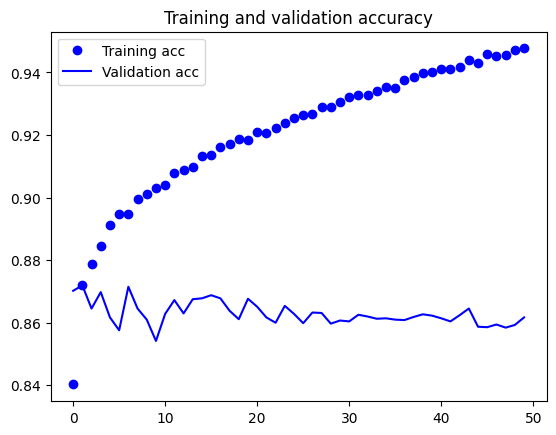

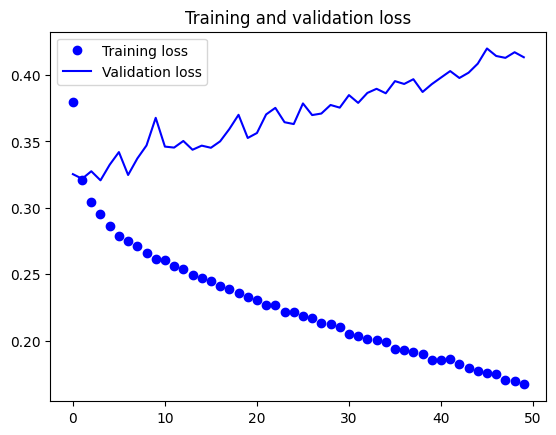

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Pretrained Model VGG16

In [30]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The VGG16 model

In [31]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [32]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

We will add a dense layer after our conv_base NN

In [33]:
from keras import models
from keras import layers

modelPreT = models.Sequential()
modelPreT.add(conv_base)

modelPreT.add(layers.Flatten())
modelPreT.add(layers.Dense(256, activation='relu')) # modelPreT.add(layers.Dropout(0.5))
modelPreT.add(layers.Dense(1, activation='sigmoid'))

In [34]:
modelPreT.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the VGG16

In [35]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreT.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [36]:
conv_base.trainable = False

In [37]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(modelPreT.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [38]:
modelPreT.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#       rescale=1./255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )


In [40]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')





Found 22000 images belonging to 2 classes.
Found 7050 images belonging to 2 classes.


In [42]:
modelPreT.compile(loss='binary_crossentropy',
              optimizer='Adagrad',
              metrics=['acc'])

In [43]:
len(train_generator)

1100

In [44]:
history = modelPreT.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 10s - loss: 0.4703 - acc: 0.7960 - val_loss: 0.3883 - val_acc: 0.8360 - 10s/epoch - 101ms/step
Epoch 2/30
100/100 - 9s - loss: 0.4028 - acc: 0.8300 - val_loss: 0.3988 - val_acc: 0.8330 - 9s/epoch - 89ms/step
Epoch 3/30
100/100 - 9s - loss: 0.3486 - acc: 0.8550 - val_loss: 0.3582 - val_acc: 0.8610 - 9s/epoch - 90ms/step
Epoch 4/30
100/100 - 9s - loss: 0.3735 - acc: 0.8405 - val_loss: 0.3773 - val_acc: 0.8340 - 9s/epoch - 89ms/step
Epoch 5/30
100/100 - 9s - loss: 0.3694 - acc: 0.8395 - val_loss: 0.3519 - val_acc: 0.8550 - 9s/epoch - 89ms/step
Epoch 6/30
100/100 - 9s - loss: 0.3349 - acc: 0.8595 - val_loss: 0.3298 - val_acc: 0.8670 - 9s/epoch - 90ms/step
Epoch 7/30
100/100 - 9s - loss: 0.3579 - acc: 0.8495 - val_loss: 0.3463 - val_acc: 0.8730 - 9s/epoch - 89ms/step
Epoch 8/30
100/100 - 9s - loss: 0.3208 - acc: 0.8730 - val_loss: 0.3638 - val_acc: 0.8460 - 9s/epoch - 90ms/step
Epoch 9/30
100/100 - 9s - loss: 0.3267 - acc: 0.8650 - val_loss: 0.3061 - val_acc: 0.8890 - 9

In [45]:
modelPreT.save(os.path.join('models','VGG16_Frozen_Plus_Dense_layers.h5'))

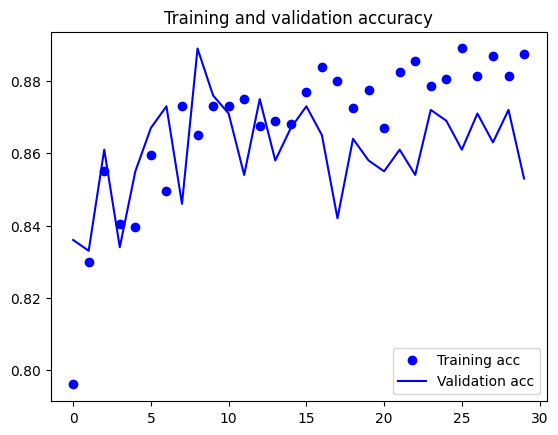

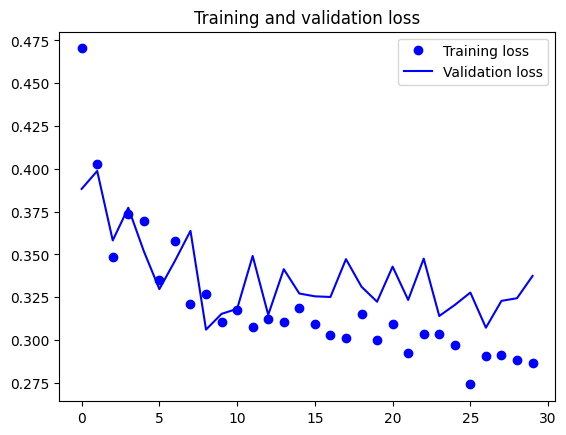

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [66]:
from keras.applications import VGG16

vgg_conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [67]:
vgg_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [68]:
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 4    

In [69]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg_conv_base.layers)

In [70]:
num_layers

19

In [71]:
# Freeze the initial layers in the convolutional base.
for model_layer in vgg_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

FREEZING LAYER: <keras.engine.input_layer.InputLayer object at 0x000001C311743310>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C311C11CD0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C31133F7F0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C311C11400>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C3117459D0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C31133F8E0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C311C11CA0>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C311742640>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C311C11B20>
FREEZING LAYER: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001C311C2C4C0>
FREEZING LAYER: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C311C2C6D0>
FREEZING LAYER: 

In [72]:
print("\n")
print(f"Configured to fine tune the last", num_layers_fine_tune, "convolutional layers...")
print("\n")
     
print(vgg_conv_base.summary())



Configured to fine tune the last 4 convolutional layers...


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                

In [ ]:
# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [73]:
from keras import models
from keras import layers

modelPreTFE = models.Sequential()
modelPreTFE.add(vgg_conv_base)

modelPreTFE.add(layers.Flatten())
modelPreTFE.add(layers.Dense(256, activation='relu')) # modelPreT.add(layers.Dropout(0.5))
modelPreTFE.add(layers.Dropout(0.5))
modelPreTFE.add(layers.Dense(1, activation='sigmoid'))

In [74]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTFE.trainable_weights))

This is the number of trainable weights before freezing the conv base: 10


In [75]:
modelPreTFE.compile(loss='binary_crossentropy',
              optimizer='Adagrad',
              metrics=['acc'])

history = modelPreTFE.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
50/50 [==============================] - 8s 143ms/step - loss: 0.5622 - acc: 0.7100 - val_loss: 0.3998 - val_acc: 0.8260
Epoch 2/100
50/50 [==============================] - 7s 138ms/step - loss: 0.3876 - acc: 0.8320 - val_loss: 0.3715 - val_acc: 0.8350
Epoch 3/100
50/50 [==============================] - 7s 138ms/step - loss: 0.3709 - acc: 0.8560 - val_loss: 0.3444 - val_acc: 0.8540
Epoch 4/100
50/50 [==============================] - 7s 139ms/step - loss: 0.3580 - acc: 0.8640 - val_loss: 0.3494 - val_acc: 0.8570
Epoch 5/100
50/50 [==============================] - 7s 139ms/step - loss: 0.3749 - acc: 0.8350 - val_loss: 0.3913 - val_acc: 0.8140
Epoch 6/100
50/50 [==============================] - 7s 139ms/step - loss: 0.3352 - acc: 0.8550 - val_loss: 0.3439 - val_acc: 0.8480
Epoch 7/100
50/50 [==============================] - 7s 139ms/step - loss: 0.2871 - acc: 0.8760 - val_loss: 0.3132 - val_acc: 0.8820
Epoch 8/100
50/50 [==============================] - 7s 139ms/step - 

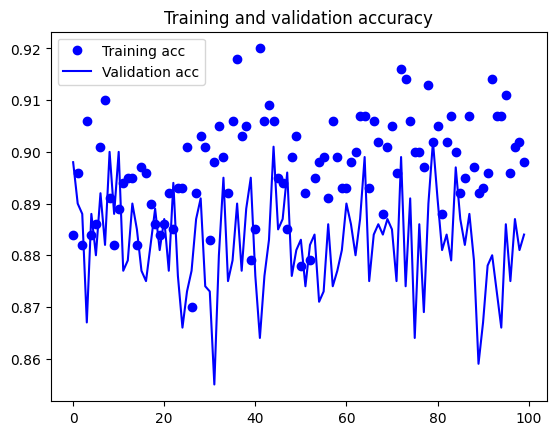

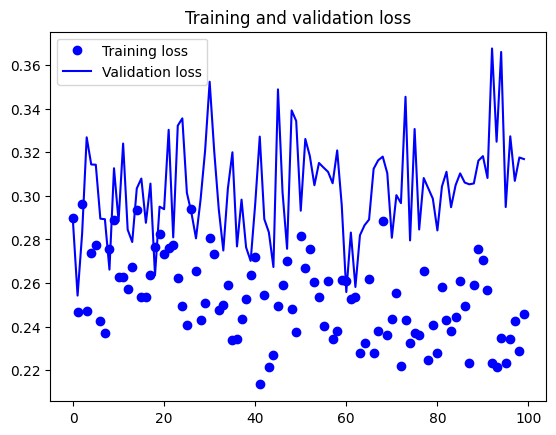

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()